<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Tutorials/PyTorch/What_Is_Torch_NN_Really/What_Is_Torch_NN_Really.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Torch.NN Really? - PyTorch Tutorial

**Author:** Suresh Venkatesan

# Import required libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import os
import shutil
import pytz
import math
import requests
import pickle
import gzip
%matplotlib inline

from pathlib import Path
from IPython.core.debugger import set_trace

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Import dataset

In [2]:
# Download mnist.pkl.gz and copy to /data/mnist folder

data_path = Path("data") / "mnist" # Define /data/mnist path as PosixPath object
data_path.mkdir(parents = True, exist_ok = True)

mnist_url = "https://github.com/pytorch/tutorials/raw/master/_static/"
mnist_fname = "mnist.pkl.gz"

# Download zip file
if not (data_path / mnist_fname).exists():
  content = requests.get(mnist_url + mnist_fname).content
  (data_path / mnist_fname).open("wb").write(content)
  print("mnist.pkl.gz created")
else:
  print("mnist.pkl.gz already exists.")
print()

# Unzip zip file and load pickle file contents
with gzip.open((data_path / mnist_fname).as_posix(), "rb") as f:
        ((X_train, y_train), (X_val, y_val), (X_test, y_test)) = pickle.load(f, encoding="latin-1")
print(f"Shape of X_train is {X_train.shape}")
print(f"Shape of X_val is {X_val.shape}")
print(f"Shape of X_test is {X_test.shape}")
print()
print(f"Shape of y_train is {y_train.shape}")
print(f"Shape of y_val is {y_val.shape}")
print(f"Shape of y_test is {y_test.shape}")

mnist.pkl.gz created

Shape of X_train is (50000, 784)
Shape of X_val is (10000, 784)
Shape of X_test is (10000, 784)

Shape of y_train is (50000,)
Shape of y_val is (10000,)
Shape of y_test is (10000,)


# View one image

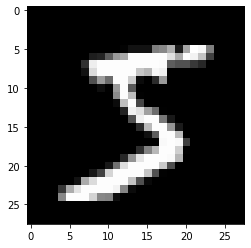

In [3]:
img = X_train[0].reshape((28, 28))
plt.imshow(img, cmap = 'gray');

# Convert numpy arrays to PyTorch tensors

In [4]:
X_train, X_val, X_test = map(torch.tensor, (X_train, X_val, X_test))
y_train, y_val, y_test = map(torch.tensor, (y_train, y_val, y_test)) 

print(f"Shape of X_train is {X_train.shape}")
print(f"Shape of X_val is {X_val.shape}")
print(f"Shape of X_test is {X_test.shape}")
print()
print(f"Shape of y_train is {y_train.shape}")
print(f"Shape of y_val is {y_val.shape}")
print(f"Shape of y_test is {y_test.shape}")

Shape of X_train is torch.Size([50000, 784])
Shape of X_val is torch.Size([10000, 784])
Shape of X_test is torch.Size([10000, 784])

Shape of y_train is torch.Size([50000])
Shape of y_val is torch.Size([10000])
Shape of y_test is torch.Size([10000])


# Build NN from scratch

## Define weights and bias

In [5]:
# Define weights and bias 
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)
print(weights.shape, bias.shape)

torch.Size([784, 10]) torch.Size([10])


## Define functions

In [6]:
def log_softmax(x): # Log softmax function
    return x - x.exp().sum(-1).log().unsqueeze(-1)
def model(xb): # Logistic regression model
    return log_softmax(xb @ weights + bias)   
def loss_func(input, target): # Negative Log-Likelihood loss function
    return -input[range(target.shape[0]), target].mean() 
def accuracy(out, yb): # Accuracy computation
    preds = torch.argmax(out, dim = 1)
    return (preds == yb).float().mean()

## Check functions

In [7]:
bat_size = 64
X_batch = X_train[0:bat_size]
y_batch = y_train[0:bat_size]
pred_batch = model(X_batch)

n, c = X_train.shape
print(n, c)

print(loss_func(pred_batch, y_batch))
print(accuracy(pred_batch, y_batch))

50000 784
tensor(2.3802, grad_fn=<NegBackward>)
tensor(0.0312)


## Build and run training loop

In [8]:
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs): # Loop through epochs
    for i in range((n - 1) // bat_size + 1): # Loop through batchs
        start_i = i * bat_size
        end_i = start_i + bat_size
        xb = X_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        # set_trace()
        acc = 100 * accuracy(pred, yb)
        # print(f"Epoch: {epoch}, Batch: {i}, Loss:{loss:0.4f}, Accuracy: {acc:0.2f}")
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    print(f"Epoch {epoch + 1} completed")            

Epoch 1 completed
Epoch 2 completed


## Evaluate loss function and accuracy after training

In [9]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0789, grad_fn=<NegBackward>) tensor(1.)


# Refactor using torch.nn.functional

Remove manual activation function and loss function. Replace with F.cross_entropy

In [10]:
loss_func = F.cross_entropy # Cross-entropy loss function (includes log-softmax and NLL loss function)

def model(xb): # Remove log-softmax from model
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0789, grad_fn=<NllLossBackward>) tensor(1.)


<b>Same results as above obtained.</b>

# Refactor using nn.Module

Next up, we'll use ``nn.Module`` and ``nn.Parameter``, for a clearer and more concise training loop. We subclass ``nn.Module`` (which itself is a class and
able to keep track of state).  In this case, we want to create a class that holds our weights, bias, and method for the forward step.  ``nn.Module`` has a
number of attributes and methods (such as ``.parameters()`` and ``.zero_grad()``) which we will be using.

In [11]:
# Define class Mnist_Logistic
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [27]:
# Instantiate a model of the above class
model = Mnist_Logistic()
print(model.weights.shape)
print(model.bias.shape)

torch.Size([784, 10])
torch.Size([10])


<b>Note: ``nn.Module`` objects are used as if they are functions (i.e they are *callable*), but behind the scenes Pytorch will call our ``forward`` method automatically.</b>



In [28]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.1889, grad_fn=<NllLossBackward>) tensor(0.1250)


Previously for our training loop we had to update the values for each parameter by name, and manually zero out the grads for each parameter separately, like this:
::
 
  with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()


Now we can take advantage of model.parameters() and model.zero_grad() (which are both defined by PyTorch for ``nn.Module``) to make those steps more concise
and less prone to the error of forgetting some of our parameters, particularly if we had a more complicated model:
::

  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()


We'll wrap our little training loop in a ``fit`` function so we can run it again later.

In [29]:
# Define model fit function
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bat_size + 1):
            start_i = i * bat_size
            end_i = start_i + bat_size
            xb = X_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        acc = 100 * accuracy(model(xb), yb)
        print(f"Epoch: {epoch + 1}, Loss: {loss:0.2f}, Accuracy: {acc:0.2f}")

In [30]:
# Fit model
fit()

Epoch: 1, Loss: 0.41, Accuracy: 100.00
Epoch: 2, Loss: 0.32, Accuracy: 100.00


In [31]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0838, grad_fn=<NllLossBackward>) tensor(1.)


# Refactor using nn.Linear

Next, instead of manually defining and initializing ``self.weights`` and ``self.bias``, and calculating ``xb  @ self.weights + self.bias``, we will instead use the Pytorch class [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear-layers) for a
linear layer, which does all that for us. 



In [ ]:
# Re-define Mnist_Logistic class using nn.Linear class
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [40]:
# Instantiate model
model = Mnist_Logistic()
for param in model.parameters():
  print(param)
  print(param.shape)
  print()

Parameter containing:
tensor([[-2.2920e-02, -1.7520e-02, -2.0168e-02,  ...,  1.7757e-02,
         -2.2948e-02, -1.3882e-02],
        [ 6.9174e-03, -8.5079e-03,  8.3044e-03,  ..., -4.2530e-02,
          8.4875e-03, -5.4977e-02],
        [-2.2831e-03,  4.6536e-02,  2.1071e-02,  ...,  3.9327e-02,
          1.3974e-02, -5.1229e-05],
        ...,
        [ 1.3525e-02,  6.8378e-02,  5.0179e-03,  ..., -4.3512e-02,
          1.7602e-02,  8.4054e-02],
        [ 5.9726e-03, -3.9827e-02,  8.9958e-03,  ...,  5.3551e-03,
         -2.9328e-02, -5.2128e-02],
        [ 2.3544e-03,  1.0047e-02,  1.5148e-02,  ..., -1.0419e-02,
         -1.5376e-02,  3.3482e-02]], requires_grad=True)
torch.Size([784, 10])

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
torch.Size([10])



In [42]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.4906, grad_fn=<NllLossBackward>) tensor(0.)


In [43]:
# Fit model
fit()

Epoch: 1, Loss: 0.40, Accuracy: 100.00
Epoch: 2, Loss: 0.31, Accuracy: 100.00


In [44]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0819, grad_fn=<NllLossBackward>) tensor(1.)


# Refactor using optim

Pytorch also has a package with various optimization algorithms, ``torch.optim``. We can use the ``step`` method from our optimizer to take a forward step, instead of manually updating each parameter.

This will let us replace our previous manually coded optimization step:

::
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()

and instead use just:
::

  opt.step()
  opt.zero_grad()

(``optim.zero_grad()`` resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch.)

In [46]:
# Define get_model function
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr = lr)

In [47]:
model, opt = get_model()
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.2717, grad_fn=<NllLossBackward>) tensor(0.0625)


In [48]:
for epoch in range(epochs):
    for i in range((n - 1) // bat_size + 1):
        start_i = i * bat_size
        end_i = start_i + bat_size
        xb = X_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    acc = 100 * accuracy(model(xb), yb)
    print(f"Epoch: {epoch + 1}, Loss: {loss:0.2f}, Accuracy: {acc:0.2f}")        

Epoch: 1, Loss: 0.40, Accuracy: 100.00
Epoch: 2, Loss: 0.31, Accuracy: 100.00


In [49]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0806, grad_fn=<NllLossBackward>) tensor(1.)


# Pending

Refactor using Dataset
------------------------------

PyTorch has an abstract Dataset class.  A Dataset can be anything that has
a ``__len__`` function (called by Python's standard ``len`` function) and
a ``__getitem__`` function as a way of indexing into it.
`This tutorial <https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>`_
walks through a nice example of creating a custom ``FacialLandmarkDataset`` class
as a subclass of ``Dataset``.

PyTorch's `TensorDataset <https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset>`_
is a Dataset wrapping tensors. By defining a length and way of indexing,
this also gives us a way to iterate, index, and slice along the first
dimension of a tensor. This will make it easier to access both the
independent and dependent variables in the same line as we train.



In [ ]:
from torch.utils.data import TensorDataset

Both ``x_train`` and ``y_train`` can be combined in a single ``TensorDataset``,
which will be easier to iterate over and slice.



In [ ]:
train_ds = TensorDataset(x_train, y_train)

Previously, we had to iterate through minibatches of x and y values separately:
::
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]


Now, we can do these two steps together:
::
    xb,yb = train_ds[i*bs : i*bs+bs]




In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

Refactor using DataLoader
------------------------------

Pytorch's ``DataLoader`` is responsible for managing batches. You can
create a ``DataLoader`` from any ``Dataset``. ``DataLoader`` makes it easier
to iterate over batches. Rather than having to use ``train_ds[i*bs : i*bs+bs]``,
the DataLoader gives us each minibatch automatically.



In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

Previously, our loop iterated over batches (xb, yb) like this:
::
      for i in range((n-1)//bs + 1):
          xb,yb = train_ds[i*bs : i*bs+bs]
          pred = model(xb)

Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:
::
      for xb,yb in train_dl:
          pred = model(xb)



In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

Thanks to Pytorch's ``nn.Module``, ``nn.Parameter``, ``Dataset``, and ``DataLoader``,
our training loop is now dramatically smaller and easier to understand. Let's
now try to add the basic features necessary to create effective models in practice.

Add validation
-----------------------

In section 1, we were just trying to get a reasonable training loop set up for
use on our training data.  In reality, you **always** should also have
a `validation set <https://www.fast.ai/2017/11/13/validation-sets/>`_, in order
to identify if you are overfitting.

Shuffling the training data is
`important <https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks>`_
to prevent correlation between batches and overfitting. On the other hand, the
validation loss will be identical whether we shuffle the validation set or not.
Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We'll use a batch size for the validation set that is twice as large as
that for the training set. This is because the validation set does not
need backpropagation and thus takes less memory (it doesn't need to
store the gradients). We take advantage of this to use a larger batch
size and compute the loss more quickly.



In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

Create fit() and get_data()
----------------------------------

We'll now do a little refactoring of our own. Since we go through a similar
process twice of calculating the loss for both the training set and the
validation set, let's make that into its own function, ``loss_batch``, which
computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.



In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

``fit`` runs the necessary operations to train our model and compute the
training and validation losses for each epoch.



In [ ]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

``get_data`` returns dataloaders for the training and validation sets.



In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the
model can be run in 3 lines of code:



In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

You can use these basic 3 lines of code to train a wide variety of models.
Let's see if we can use them to train a convolutional neural network (CNN)!

Switch to CNN
-------------

We are now going to build our neural network with three convolutional layers.
Because none of the functions in the previous section assume anything about
the model form, we'll be able to use them to train a CNN without any modification.

We will use Pytorch's predefined
`Conv2d <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d>`_ class
as our convolutional layer. We define a CNN with 3 convolutional layers.
Each convolution is followed by a ReLU.  At the end, we perform an
average pooling.  (Note that ``view`` is PyTorch's version of numpy's
``reshape``)



In [ ]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

`Momentum <https://cs231n.github.io/neural-networks-3/#sgd>`_ is a variation on
stochastic gradient descent that takes previous updates into account as well
and generally leads to faster training.



In [ ]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

nn.Sequential
------------------------

``torch.nn`` has another handy class we can use to simplify our code:
`Sequential <https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential>`_ .
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a
**custom layer** from a given function.  For instance, PyTorch doesn't
have a `view` layer, and we need to create one for our network. ``Lambda``
will create a layer that we can then use when defining a network with
``Sequential``.



In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model created with ``Sequential`` is simply:



In [ ]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Wrapping DataLoader
-----------------------------

Our CNN is fairly concise, but it only works with MNIST, because:
 - It assumes the input is a 28\*28 long vector
 - It assumes that the final CNN grid size is 4\*4 (since that's the average
pooling kernel size we used)

Let's get rid of these two assumptions, so our model works with any 2d
single channel image. First, we can remove the initial Lambda layer by
moving the data preprocessing into a generator:



In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace ``nn.AvgPool2d`` with ``nn.AdaptiveAvgPool2d``, which
allows us to define the size of the *output* tensor we want, rather than
the *input* tensor we have. As a result, our model will work with any
size input.



In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Let's try it out:



In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Using your GPU
---------------

If you're lucky enough to have access to a CUDA-capable GPU (you can
rent one for about $0.50/hour from most cloud providers) you can
use it to speed up your code. First check that your GPU is working in
Pytorch:



In [ ]:
print(torch.cuda.is_available())

And then create a device object for it:



In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's update ``preprocess`` to move batches to the GPU:



In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Finally, we can move our model to the GPU.



In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

You should find it runs faster now:



In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Closing thoughts
-----------------

We now have a general data pipeline and training loop which you can use for
training many types of models using Pytorch. To see how simple training a model
can now be, take a look at the `mnist_sample` sample notebook.

Of course, there are many things you'll want to add, such as data augmentation,
hyperparameter tuning, monitoring training, transfer learning, and so forth.
These features are available in the fastai library, which has been developed
using the same design approach shown in this tutorial, providing a natural
next step for practitioners looking to take their models further.

We promised at the start of this tutorial we'd explain through example each of
``torch.nn``, ``torch.optim``, ``Dataset``, and ``DataLoader``. So let's summarize
what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.

